# Introduction
In this project, we are doing data analysis for Megaline, a telecom operator.  The company offers two prepaid plans, called Surf and Ultimate.  The marketing department has asked us to determine which plan brings in more revenue, so that they can adjust their advertising budget.

Our analysis will be based on a sample of 500 clients during the year 2018.  We will analyze clients' usage of the service (phone calls, text messages, and data) and determine which plan brings in more revenue.

In order to draw valid conclusions, the sample should be representative of the entire population of Megaline clients.  The sample should approximate the population in terms of such factors as geographic distribution, ages of customers, and, of course, usage patterns.  The sample should have similar the proportions of clients on the two plans.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import numpy as np
from functools import reduce
import seaborn as sns
from scipy.stats import levene
import warnings

warnings.filterwarnings('ignore')

try:
    df_pln = pd.read_csv('megaline_plans.csv')
    df_usr = pd.read_csv('megaline_users.csv')
    df_call = pd.read_csv('megaline_calls.csv')
    df_msg = pd.read_csv('megaline_messages.csv')
    df_net = pd.read_csv('megaline_internet.csv')
except:
    df_pln = pd.read_csv('/datasets/megaline_plans.csv')
    df_usr = pd.read_csv('/datasets/megaline_users.csv')
    df_call = pd.read_csv('/datasets/megaline_calls.csv')
    df_msg = pd.read_csv('/datasets/megaline_messages.csv')
    df_net = pd.read_csv('/datasets/megaline_internet.csv')

# Initial data review
In this section, we will take a preliminary look at 5 dataframes.
- Plans:  Provides parameters on the Surf and Ultimate plans, i.e., monthly fee, monthly limits for calls, messages, and data, and rates for usage that exceeds the limits.
- Users:  Provides information on the 500 users sampled.
- Calls:  Lists the phone calls and their durations during the year.
- Messages:  Lists text messages sent.
- Internet:  Lists data usage.

## Plans

In [2]:
df_pln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [3]:
df_pln

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Th <code>df_plans</code> dataframe describes the two prepaid plans that Megaline offers, Surf and Ultimate.  I note that the number of MB included is the binary equivalent rather than decimal.  The data types are appropriate:  integer types for whole numbers, float types for decimal numbers, and a string for the plan name.

## Users

In [4]:
df_usr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
df_usr.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Data types are appropriate, except for <code>reg_date</code>, which should be <code>datatime</code>.  There are no true missing values; the <code>NaN</code> values for <code>churn_date</code> indicate that the plan was still being used when the data was extracted.  The city column refers to a Metropolitan Service Area (MSA).  This often encompasses several cities, which in some cases are located in adjoining states.

## Calls

In [6]:
df_call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [7]:
df_call.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


The <code>id</code> appears to be the <code>user_id</code> joined by an underscore to a unique number for each call.  <code>call_date</code> should be <code>datetime</code>.  There do not appear to be any missing values.

Let's inspect the distribution of calls, looking for any anomalies in the data.

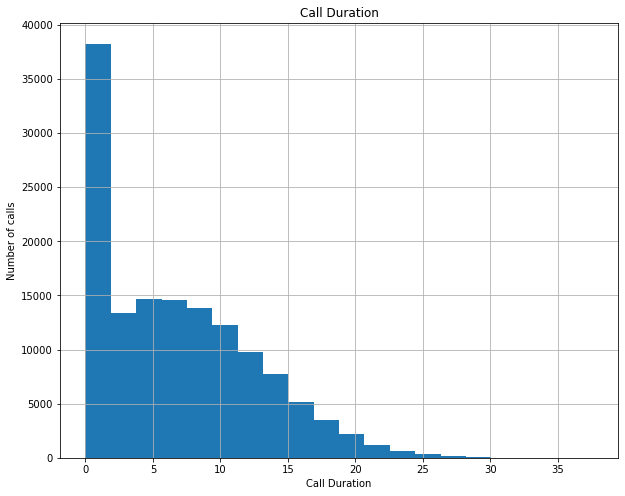

In [8]:
plt.figure(figsize=(10,8))
plt.hist(df_call['duration'], bins=20)
plt.title('Call Duration')
plt.xlabel('Call Duration')
plt.ylabel('Number of calls')
plt.grid()
plt.show()

This histogram, which shows the distribution of the length of calls, shows a large peak at or near zero.  Let's manually inspect calls lasting less than a minute.

In [9]:
df_call.query('duration < 1').head()

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0.00
25,1001_13,1001,2018-12-24,0.00
28,1001_23,1001,2018-10-27,0.98
31,1001_30,1001,2018-10-17,0.00
32,1001_31,1001,2018-11-03,0.00


Many calls have a length of zero.  The most likely explanation is that the call went unanswered.  Megaline rounds up calls lasting one second to a minute, but these calls didn't even last a second.  These are not true missing values, and since Megaline doesn't bill for them, it does not make sense to fill in an average default value.  These calls will have no effect on revenue calculations and can be safely excluded from further analysis.

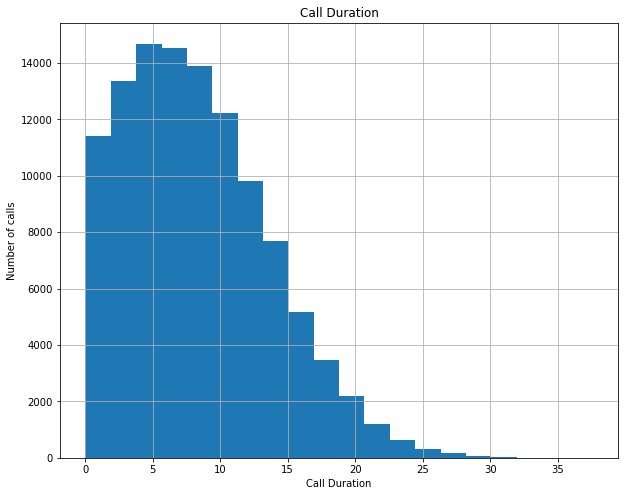

In [10]:
zero_duration_indices = df_call[df_call['duration'] == 0].index
df_call.drop(zero_duration_indices, inplace=True)

plt.figure(figsize=(10,8))
plt.hist(df_call['duration'], bins=20)
plt.title('Call Duration')
plt.xlabel('Call Duration')
plt.ylabel('Number of calls')
plt.grid()
plt.show()

## Messages

In [11]:
df_msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [12]:
df_msg.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


The messages dataframe is similar to the calls dataframe.  There are no apparent missing values.  <code>message_date</code> should be <code>datetime</code>.

## Internet

In [13]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [14]:
df_net.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


As with the calls and messages dataframes, we will convert <code>session_date</code> to <code>datetime</code>.

Let's have a look at the distribution of internet data usage.

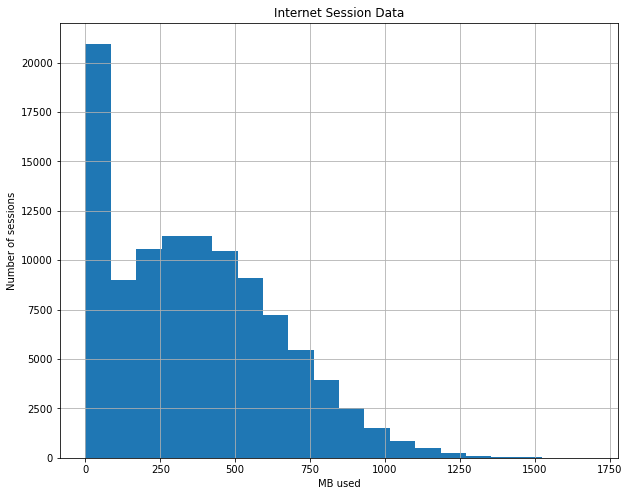

In [15]:
plt.figure(figsize=(10,8))
plt.hist(df_net['mb_used'], bins=20)
plt.title('Internet Session Data')
plt.xlabel('MB used')
plt.ylabel('Number of sessions')
plt.grid()
plt.show()

In [16]:
df_net.query('mb_used < 1').head()

,id,user_id,session_date,mb_used
1,1000_204,1000,2018-12-31,0.0
14,1001_26,1001,2018-09-17,0.0
16,1001_28,1001,2018-10-17,0.0
34,1001_54,1001,2018-09-02,0.0
43,1001_77,1001,2018-10-31,0.0


Similar to the situation with phone calls of zero length, there are many internet sessions with no data transmitted.  This could represent a dropped connection or a session where the client navigated away from a URL before receiving a response from the server.  These sessions do not have an impact on revenue.

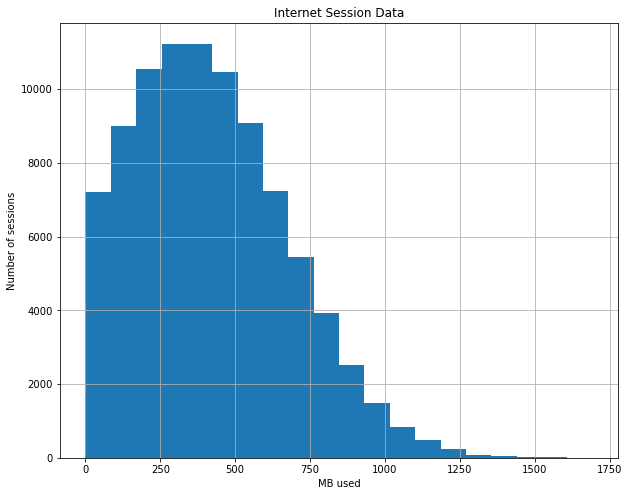

In [17]:
zero_data_indices = df_net[df_net['mb_used'] == 0].index
df_net.drop(zero_data_indices, inplace=True)

plt.figure(figsize=(10,8))
plt.hist(df_net['mb_used'], bins=20)
plt.title('Internet Session Data')
plt.xlabel('MB used')
plt.ylabel('Number of sessions')
plt.grid()
plt.show()

## Clients with no usage
The Surf and Ultimate plans include three services (phone calls, text messages, and internet data), but not all clients use all services.  If there are clients who did not use _any_ services in 2018, they will not appear in our analysis.

In [18]:
all_users = set(df_usr['user_id'].values)
call_users = set(df_call['user_id'].unique())
msg_users = set(df_msg['user_id'].unique())
net_users = set(df_net['user_id'].unique())
non_users = all_users - call_users - msg_users - net_users
df_usr.loc[df_usr['user_id'].isin(list(non_users))]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
25,1025,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,NaN
129,1129,Marin,Bolton,70,"Baton Rouge, LA MSA",2018-11-10,surf,2018-12-27
143,1143,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,NaN
269,1269,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15
275,1275,Elvie,Velazquez,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,ultimate,NaN
307,1307,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaN
319,1319,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaN
378,1378,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaN
463,1463,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,NaN
473,1473,Kirk,Velez,61,"Louisville/Jefferson County, KY-IN MSA",2018-12-31,surf,NaN


These ten users signed up for a plan but did not have any call, message, or internet usage in 2018.  In general, these users registered later in the year than the typical user.  Two of them registered on the last day of the year, so it makes sense that they didn't have any usage in 2018.  Two others registered late in the year and canceled in December.  Because of these users, our combined usage data will only represent 490 users, rather than 500.

## Conclusion
In this section, we did an initial review of the five dataframes for the project.
- The plans dataframe describes the two prepaid plans.
- The users dataframe lists the user's location, plan, registration date, and churn date.  The <code>reg_date</code> will be converted to <code>datetime</code>.
- The calls, messages, and internet dataframes provide usage data.  Dates will be converted to <code>datetime</code>.
- There are 10 users who signed up for a plan but did not have any calls, messages, or data usage during 2018.

We can begin to think ahead to how we will merge the data.  Ultimately, for hypothesis testing, we will need a table with a row for each user, with columns for geographic location, plan, and average monthly revenue.  To get to this point, will need usage data for each user on a monthly basis.

# Preprocessing
In this section, we will make the data type changes identified above and will merge the dataframes for subsequent analysis and hypothesis testing.

## Users
We will convert <code>reg_date</code> to <code>datetime</code>.  We can also convert <code>churn_date</code> to <code>datetime</code>, although the column as a whole will still be <code>object</code> type because most clients did not churn during 2018.

In [19]:
df_usr['reg_date'] = pd.to_datetime(df_usr['reg_date'], format='%Y-%m-%d')
df_usr['churn_date'] = pd.to_datetime(df_usr['churn_date'], format='%Y-%m-%d')

## Calls
In this section, we will apply several changes to the data.
-  We will convert <code>call_date</code> to <code>datetime</code>.
-  Since we will be looking at average monthly usage for each user, we will create a new column for the <code>month</code> the call was placed; this will be used later to merge the calls dataframe with the users, messages, and internet dataframes.
- Megaline rounds all calls (even one second) up to to the next minute, so we will round up the <code>call_duration</code> column accordingly.
-  Finally, we will create a pivot table to be used later for merging.

In [20]:
# Convert to datetime
df_call['call_date'] = pd.to_datetime(df_call['call_date'], format='%Y-%m-%d')

# Add month column
df_call['month'] = pd.DatetimeIndex(df_call['call_date']).month

# Round up call_duration
df_call['duration'] = df_call['duration'].apply(np.ceil)

# Create pivot table
df_call_pivot = df_call.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum','count'])
df_call_pivot.columns = ['call_duration', 'call_count']
df_call_pivot.reset_index(inplace=True)
df_call_pivot.head()

,user_id,month,call_duration,call_count
0,1000,12,124.0,16
1,1001,8,182.0,22
2,1001,9,315.0,38
3,1001,10,393.0,47
4,1001,11,426.0,49


## Messages
We will process the messages dataframe in a manner similar to the calls dataframe:  convert <code>message_date</code> to <code>datetime</code>, create a new <code>month</code> column, and create a table for subsequent merging.

In [21]:
df_msg['message_date'] = pd.to_datetime(df_msg['message_date'], format='%Y-%m-%d')
df_msg['month'] = pd.DatetimeIndex(df_msg['message_date']).month
df_msg_pivot = df_msg.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
df_msg_pivot.columns = ['messages']
df_msg_pivot.reset_index(inplace=True)
df_msg_pivot.head()

,user_id,month,messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


## Internet
We will process the internet dataframe in a manner similar to the calls and messages dataframes.

In [22]:
df_net['session_date'] = pd.to_datetime(df_net['session_date'], format='%Y-%m-%d')
df_net['month'] = pd.DatetimeIndex(df_net['session_date']).month
df_net_pivot = df_net.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
df_net_pivot.reset_index(inplace=True)
df_net_pivot.head()

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


## Combined usage data
In this section we will merge the calls, messages, internet, and users dataframes.  These will be <code>outer</code> merges since we want to include records present in _either_ of the dataframes being merged.  If a client did not have a particular type of usage, the merged dataframe will have NaN values; these will be filled in with zeroes.

In [23]:
#df = df_call_pivot.merge(df_msg_pivot, on=['user_id','month'], how='outer').merge(df_net_pivot, on=['user_id','month'], how='outer')

df = reduce(lambda left, right: pd.merge(left, right, 
                                         on=['user_id','month'], 
                                         how='outer'), 
            [df_call_pivot, df_msg_pivot, df_net_pivot])

df.fillna(value=0, inplace=True)
df = df.merge(df_usr, on='user_id')
df.head()

,user_id,month,call_duration,call_count,messages,mb_used,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12,124.0,16.0,11.0,1901.47,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,8,182.0,22.0,30.0,6919.15,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1001,9,315.0,38.0,44.0,13314.82,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
3,1001,10,393.0,47.0,53.0,22330.49,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
4,1001,11,426.0,49.0,36.0,18504.30,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT


We will clean up our table by removing columns we will not be using and ordering columns logically.

In [24]:
df.drop(['first_name', 'last_name', 'age', 'reg_date', 'churn_date'], axis=1, inplace=True)
df = df[['user_id', 'city', 'plan', 'month', 'call_count', 'call_duration', 'messages', 'mb_used']]
df.head()

,user_id,city,plan,month,call_count,call_duration,messages,mb_used
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,12,16.0,124.0,11.0,1901.47
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,8,22.0,182.0,30.0,6919.15
2,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,9,38.0,315.0,44.0,13314.82
3,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10,47.0,393.0,53.0,22330.49
4,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,11,49.0,426.0,36.0,18504.30


## Revenue
In this section, we will add columns for the revenue generated by each type of usage.

### Monthly fee
The Surf plan has a lower monthly fee but also has lower usage limits and higher rates for usage that exceeds the limits.  We will add a column for the monthly fee for each plan.

In [25]:
surf_fee = df_pln.query('plan_name == "surf"').usd_monthly_pay.iloc[0]
ultimate_fee = df_pln.query('plan_name == "ultimate"').usd_monthly_pay.iloc[0]

df['monthly_fee'] = df['plan'].apply(lambda p: surf_fee if p == 'surf' else ultimate_fee)
df.head()

,user_id,city,plan,month,call_count,call_duration,messages,mb_used,monthly_fee
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,12,16.0,124.0,11.0,1901.47,70
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,8,22.0,182.0,30.0,6919.15,20
2,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,9,38.0,315.0,44.0,13314.82,20
3,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10,47.0,393.0,53.0,22330.49,20
4,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,11,49.0,426.0,36.0,18504.30,20


### Calls
Each plan has a monthly limit for calls and a rate per minute applied to calls exceeding the limit.

In [26]:
def calc_call_revenue(row):
    plan = row['plan']
    call_duration = row['call_duration']
    included = df_pln.query('plan_name == @plan').minutes_included.iloc[0]
    rate = df_pln.query('plan_name == @plan').usd_per_minute.iloc[0]
    billable_minutes = max(0, call_duration-included)
    return rate*billable_minutes

df['call_revenue'] = df.apply(calc_call_revenue, axis=1)
df.query('call_revenue > 0').head()

,user_id,city,plan,month,call_count,call_duration,messages,mb_used,monthly_fee,call_revenue
9,1003,"Tulsa, OK MSA",surf,12,118.0,1104.0,50.0,27044.14,20,18.12
23,1007,"Grand Rapids-Kentwood, MI MSA",surf,10,70.0,645.0,59.0,37885.63,20,4.35
24,1007,"Grand Rapids-Kentwood, MI MSA",surf,11,61.0,524.0,48.0,24334.00,20,0.72
25,1007,"Grand Rapids-Kentwood, MI MSA",surf,12,71.0,617.0,50.0,29069.28,20,3.51
29,1009,"San Jose-Sunnyvale-Santa Clara, CA MSA",surf,5,61.0,534.0,0.0,20389.40,20,1.02


We can check our calculation manually. Let's look at the first client in the list.  The user is on the Surf plan.  In December, they had 1,104 minutes of calls.  (Individual call times were already rounded up to the next minute in an earlier section.)  Since the Surf plan includes 500 minutes, the user's billable minutes were 604.  These are billed at \\$0.03 per minute, for a charge of \\$18.12.

### Messages
The two plans include a certain number of text messages per month, and a rate applied to messages that exceed the limits.

In [27]:
def calc_msg_revenue(row):
    plan = row['plan']
    msgs = row['messages']
    included = df_pln.query('plan_name == @plan').messages_included.iloc[0]
    rate = df_pln.query('plan_name == @plan').usd_per_message.iloc[0]
    billable_msgs = max(0, msgs-included)
    return rate*billable_msgs

df['message_revenue'] = df.apply(calc_msg_revenue, axis=1)
df.query('message_revenue > 0').head()

,user_id,city,plan,month,call_count,call_duration,messages,mb_used,monthly_fee,call_revenue,message_revenue
3,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10,47.0,393.0,53.0,22330.49,20,0.00,0.09
21,1007,"Grand Rapids-Kentwood, MI MSA",surf,8,56.0,456.0,51.0,24439.88,20,0.00,0.03
23,1007,"Grand Rapids-Kentwood, MI MSA",surf,10,70.0,645.0,59.0,37885.63,20,4.35,0.27
57,1014,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,12,125.0,1114.0,64.0,7792.41,20,18.42,0.42
58,1015,"Pittsburgh, PA MSA",surf,12,12.0,96.0,68.0,17495.12,20,0.00,0.54


Let's manually check the results.  The first user is on the Surf plan.  The user exceeded the monthly limit of 50 messages by 3 and was charged \\$0.03 per message for a total charge of \\$0.09.

### Internet
As with other usage types, each plan includes a monthly limit and a rate that is applied to data above the limit.  In the users dataframe, limits are expressed in megabytes, while the rates are per gigabyte.  Since the limits are expressed in binary rather than decimal approximations (e.g., 15 GB = 15,360 MB), we will use the binary conversion factor of 1,024 to convert MB to GB.  We will also round billable GB up to the next GB.

In [28]:
def calc_internet_revenue(row):
    plan = row['plan']
    mb = row['mb_used']
    included = df_pln.query('plan_name == @plan').mb_per_month_included.iloc[0]
    rate = df_pln.query('plan_name == @plan').usd_per_gb.iloc[0]
    billable_mb = max(0, mb-included)
    billable_gb = billable_mb/1024
    billable_gb = math.ceil(billable_gb)
    return rate*billable_gb

df['internet_revenue'] = df.apply(calc_internet_revenue, axis=1)
df.query('internet_revenue > 0').head()

,user_id,city,plan,month,call_count,call_duration,messages,mb_used,monthly_fee,call_revenue,message_revenue,internet_revenue
3,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10,47.0,393.0,53.0,22330.49,20,0.00,0.09,70
4,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,11,49.0,426.0,36.0,18504.30,20,0.00,0.00,40
5,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,12,46.0,412.0,44.0,19369.18,20,0.00,0.00,40
7,1002,"Las Vegas-Henderson-Paradise, NV MSA",surf,11,48.0,386.0,32.0,19345.08,20,0.00,0.00,40
9,1003,"Tulsa, OK MSA",surf,12,118.0,1104.0,50.0,27044.14,20,18.12,0.00,120


We will manually check our work on the first client in the table.  They are on the Surf plan.  During the month of October, they used 22,330.49 MB of data.  This exceeds the Surf limit of 15,360 MB by 6,970.49 MB.  Diving by 1,024, this is 6.8 GB, which rounds to 7 billable GB.  Applying the Surf rate of \\$10 per GB, we get revenue of $70.

### Total revenue
We will add a column for total monthly revenue, which consists of the monthly fee and the usage charges for calls, messages, and internet.

In [29]:
df['total_revenue'] = df['monthly_fee'] + df['call_revenue'] + df['message_revenue'] + df['internet_revenue']
df.head()

,user_id,city,plan,month,call_count,call_duration,messages,mb_used,monthly_fee,call_revenue,message_revenue,internet_revenue,total_revenue
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,12,16.0,124.0,11.0,1901.47,70,0.0,0.00,0,70.00
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,8,22.0,182.0,30.0,6919.15,20,0.0,0.00,0,20.00
2,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,9,38.0,315.0,44.0,13314.82,20,0.0,0.00,0,20.00
3,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10,47.0,393.0,53.0,22330.49,20,0.0,0.09,70,90.09
4,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,11,49.0,426.0,36.0,18504.30,20,0.0,0.00,40,60.00


### Average monthly revenue by user
Subsequent analysis will focus on monthly averages for each user.  Thus, we will aggregate average values by user.  We will also include the plan type and city, which will also be used later.  This table should have 490 rows, since as we saw earlier, there are 10 users with no usage during the study period.

In [30]:
df_avg = df.groupby(['user_id','plan','city'])['call_count', 'call_duration','messages','mb_used','total_revenue'].agg('mean')
df_avg.fillna(value=0, inplace=True)
print('Number of users for analysis: {}'.format(len(df_avg)))
df_avg.head()

Number of users for analysis: 490


,,,call_count,call_duration,messages,mb_used,total_revenue
user_id,plan,city,,,,,
1000,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",16.000000,124.000000,11.000000,1901.47000,70.000000
1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",40.400000,345.600000,41.400000,16087.58800,50.018000
1002,surf,"Las Vegas-Henderson-Paradise, NV MSA",31.333333,276.333333,29.333333,13431.11000,33.333333
1003,surf,"Tulsa, OK MSA",118.000000,1104.000000,50.000000,27044.14000,158.120000
1004,surf,"Seattle-Tacoma-Bellevue, WA MSA",38.250000,346.500000,22.125000,19544.10125,76.250000


## Conclusion
In this section, we prepared our data for analysis.  This consisted of these steps:
1. Converted date types from <code>string</code> to <code>datetime</code>.
2. Added a <code>month</code> for each usage type.
3. Merged the calls, messages, internet, and usage tables.
4. Added revenue-related columns.
5. Aggregated monthly data into averages for each user.

# Exploratory data analysis
In this section, we will examine usage patterns for the two plans.

## Calls

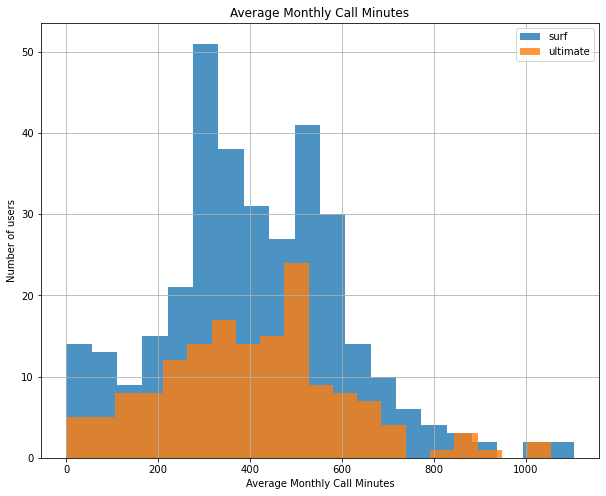

In [31]:
def plot_hist(column, title, xlabel, ylabel):
    plt.figure(figsize=(10,8))
    plt.hist(df_avg.query('plan == "surf"')[column], bins=20, alpha=0.8, label='surf')
    plt.hist(df_avg.query('plan == "ultimate"')[column], bins=20, alpha=0.8, label='ultimate')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.show()

plot_hist(column='call_duration',
          title='Average Monthly Call Minutes',
          xlabel='Average Monthly Call Minutes',
          ylabel='Number of users')

The histograms show the average number of minutes the users spent on the phone each month during the study period.  The distribution is _roughly_ normal in appearance, in the sense that it is fatter in the middle, and tapers on either side.

There are fewer clients on the Ultimate plan, but the distributions for the two plans have very similar shapes.

The Surf plan includes 500 minutes, so a significant minority of users on the plan will incur per-minute fees.  The Ultimate plan includes 3,000 minutes, so no users would be expected to incur per-minute fees.

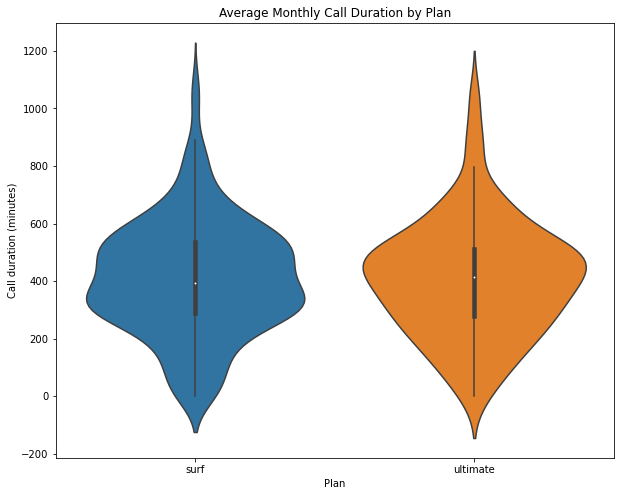

In [32]:
def plot_violin(column, title, xlabel, ylabel):
    plt.figure(figsize=(10,8))
    sns.violinplot(x=df_avg.index.get_level_values(1), y=df_avg[column], order=['surf', 'ultimate'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_violin(column='call_duration',
          title='Average Monthly Call Duration by Plan',
          xlabel='Plan',
          ylabel='Call duration (minutes)')

In [33]:
def print_stats(col):
    stats = [['Mean', 
             df_avg.query('plan == "surf"')[col].mean(),
             df_avg.query('plan == "ultimate"')[col].mean()
             ],
             ['Median', 
             df_avg.query('plan == "surf"')[col].median(),
             df_avg.query('plan == "ultimate"')[col].median()
             ],
             ['Variance',
              np.var(df_avg.query('plan == "surf"')[col]),
              np.var(df_avg.query('plan == "ultimate"')[col])
             ],
             ['Std deviation',
              np.std(df_avg.query('plan == "surf"')[col]),
              np.std(df_avg.query('plan == "ultimate"')[col])
             ]
            ]
    return pd.DataFrame(stats, columns=['Statistic', 'Surf', 'Ultimate']).set_index('Statistic').round(decimals=1)

    
print_stats('call_duration')

,Surf,Ultimate
Statistic,,
Mean,408.7,408.0
Median,394.2,415.3
Variance,39628.7,39887.3
Std deviation,199.1,199.7


As implied by the histograms, clients on the two plans have nearly identical usage patterns.  Clients spent an average of 386 mintues (6.4 hours) on the phone each month.

## Messages

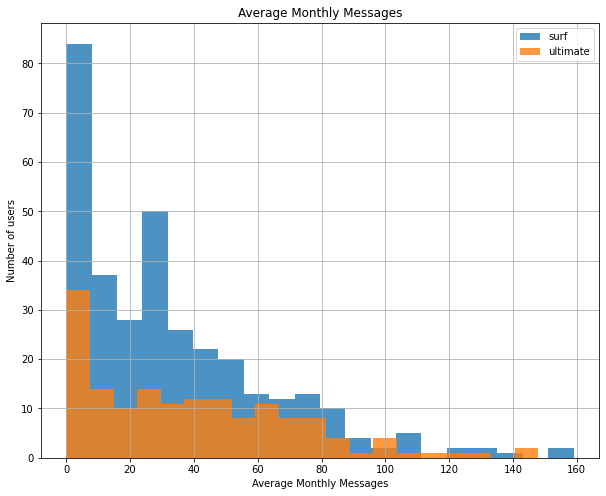

In [34]:
plot_hist(column='messages',
          title='Average Monthly Messages',
          xlabel='Average Monthly Messages',
          ylabel='Number of users')

The histograms show the average number of text messages sent per month during the study period.  Many users sent fewer than 10 texts per month.  Again, the two plans exhibit very similar usage patterns.

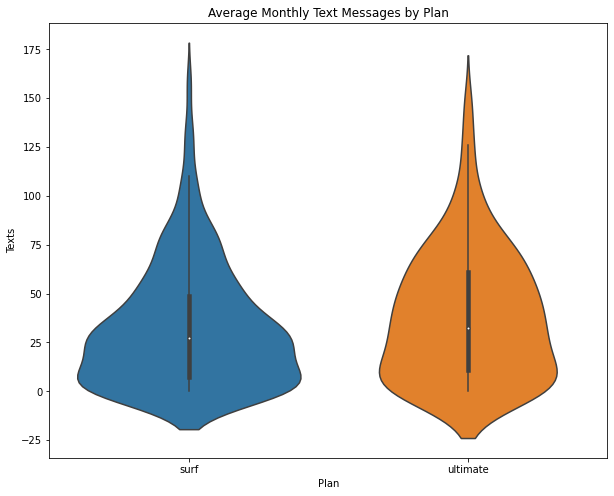

In [35]:
plot_violin(column='messages',
          title='Average Monthly Text Messages by Plan',
          xlabel='Plan',
          ylabel='Texts')

In [36]:
print_stats('messages')

,Surf,Ultimate
Statistic,,
Mean,32.4,38.5
Median,27.0,32.5
Variance,959.2,1077.3
Std deviation,31.0,32.8


Clients on the Ultimate plan sent more text messages per month than those on the Surf plan, but this difference is _much_ less than the standard deviation, suggesting that there is no statistically significant difference between the groups.

The Surf plan includes 50 messages per month, so some users on the plan will incur per-message fees.  Because the Ultimate plan includes 1,000 messages per month, no users would be expected to pay the per-message fee.

## Internet

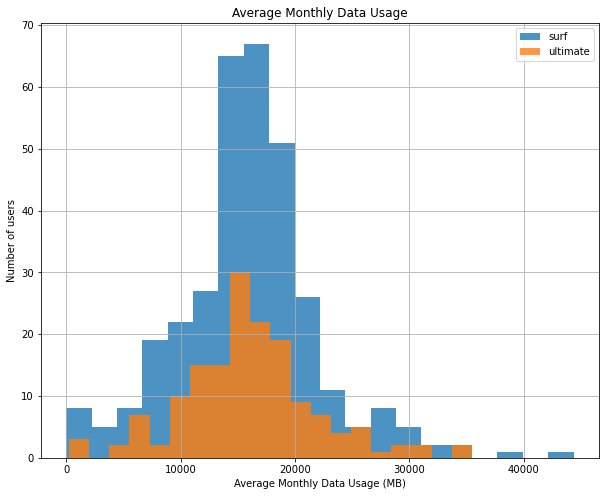

In [37]:
plot_hist(column='mb_used',
          title='Average Monthly Data Usage',
          xlabel='Average Monthly Data Usage (MB)',
          ylabel='Number of users')

The histograms show the average monthly internet usage for the two plans.  As with phone usage, the distributions are _roughly_ normal in appearance and similar to each other in shape.

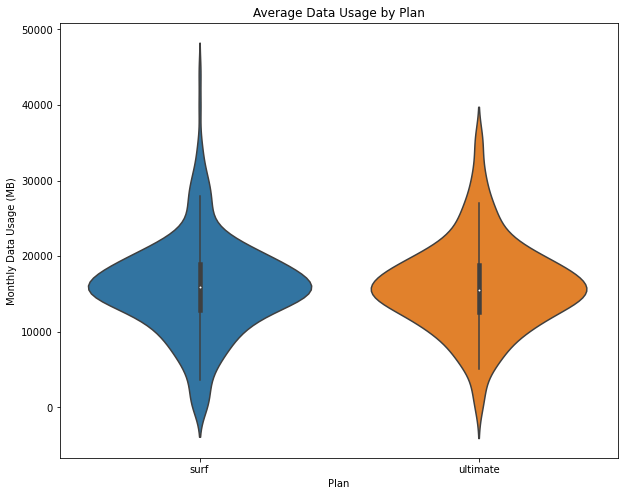

In [38]:
plot_violin(column='mb_used',
          title='Average Data Usage by Plan',
          xlabel='Plan',
          ylabel='Monthly Data Usage (MB)')

In [39]:
print_stats('mb_used')

,Surf,Ultimate
Statistic,,
Mean,15866.1,16042.3
Median,15916.5,15574.2
Variance,38644743.0,34715028.4
Std deviation,6216.5,5891.9


Clients on both plans used about 16 GB of data per month, on average.  Since the Surf plan includes 15 GB, one can surmise that many clients on this plan incurred fees for data exceeding the limit.  The Ultimate plan includes 30 GB of data, so few clients on that plan would have incurred per-GB fees.

## Revenue contribution by usage type

In [40]:
surf_total = df.query('plan == "surf"')['total_revenue'].sum()
ultimate_total = df.query('plan == "ultimate"')['total_revenue'].sum()
print('Total revenue from Surf plan: ${:.0f}.'.format(surf_total))
print('Total revenue from Ultimate plan: ${:.0f}.'.format(ultimate_total))

df_rev_plan = df.groupby('plan')['monthly_fee','call_revenue', 'message_revenue', 'internet_revenue'].agg('sum')
df_rev_plan = df_rev_plan.transpose().reset_index()
df_rev_plan.columns = ['Revenue type', 'Surf', 'Ultimate']
df_rev_plan['Surf'] = df_rev_plan['Surf'].apply(lambda x: x/surf_total*100)
df_rev_plan['Ultimate'] = df_rev_plan['Ultimate'].apply(lambda x: x/ultimate_total*100)
df_rev_plan


Total revenue from Surf plan: $95491.
Total revenue from Ultimate plan: $52066.


,Revenue type,Surf,Ultimate
0,monthly_fee,32.945451,96.800215
1,call_revenue,3.037191,0.000000
2,message_revenue,0.346556,0.000000
3,internet_revenue,63.670802,3.199785


This table shows that almost all revenue from the Ultimate plan comes from the monthly fee.  Revenue from the Surf plan comes from the montly fee and internet data, with very little contribution from texts or calls.

## Monthly revenue per user for each plan

In [41]:
df_surf = df_avg.query('plan == "surf"')
print('Surf users generate ${:.0f} per month.'.format(df_surf['total_revenue'].sum()/len(df_surf)))

df_ultimate = df_avg.query('plan == "ultimate"')
print('Ultimate users generate ${:.0f} per month.'.format(df_ultimate['total_revenue'].sum()/len(df_ultimate)))

Surf users generate $58 per month.
Ultimate users generate $72 per month.


Ultimate users bring in \\$14 more per month, on average, than Surf users.

## Conclusion
In this section, we examined usage patterns for the Surf and Ultimate plans.  Usage patterns are remarkably similar for the two plans, for all three usage types.  Clients on the Surf plan generate revenue through a combination of the monthly fee and usage fees (mostly internet).  Although the Ultimate plan has the same structure as the Surf plan, its high usage limits mean that few clients actually incur usage fees.  Instead, the Ultimate plan generates revenue through its high monthly fee.

# Hypothesis testing

The main goal of this project is to compare the revenue generated by the Surf and Ultimate plans.  The marketing team will use this information to adjust the advertising budget.

For our hypothesis tests, we will use a signifiance level (alpha) of 0.05.  This is a conventional, albeit arbitrary, choice.  If we were to choose a higher alpha, such as 0.1, we would increase the risk making a type I error, i.e., mistakenly concluding that there is a difference (rejecting the null hypothesis) when in fact there is no difference.  On the other hand, if we were to select a lower alpha, such as 0.01, we would increase the risk of making a type II error, mistakenly concluding that is is no difference (failing to reject the null hypothesis), when in fact there is a difference.

## Average revenue from users of Ultimate and Surf calling plans
The marketing department asked us to determine whether average revenue from the Surf and Ultimate plans differs.  To answer this question, we will first calculate the average revenue from each plan.

In [42]:
df_surf_rev = df_avg.query('plan == "surf"')['total_revenue'].values
print('The Surf plan has {} users with average monthly revenue of ${:.2f}. The variance is {:.0f}.'.format(len(df_surf_rev), df_surf_rev.mean(), np.var(df_surf_rev)))

df_ultimate_rev = df_avg.query('plan == "ultimate"')['total_revenue'].values
print('The Ultimate plan has {} users with average monthly revenue of ${:.2f}. The variance is {:.0f}.'.format(len(df_ultimate_rev), df_ultimate_rev.mean(), np.var(df_ultimate_rev)))

The Surf plan has 333 users with average monthly revenue of $58.19. The variance is 1892.
The Ultimate plan has 157 users with average monthly revenue of $71.82. The variance is 55.


The Ultimate plan has a higher average monthly revenue, but could this difference be due to chance?  To answer this question, we will construct a hypothesis test.
- **H<sub>0</sub>**: The average revenue of the Surf and Ultimate plans is equal.
- **H<sub>1</sub>**: The average revenue of the Surf and Ultimate plans is not equal.

In [43]:
results = levene(df_surf_rev, df_ultimate_rev)
if results.pvalue < 0.05:
    print('Levene test: revenue distributions do NOT have equal variance. (p={:.2e})'.format(results.pvalue))
else:
    print('Levene test: revenue distributions DO have equal variance. (p={:.2e})'.format(results.pvalue))

Levene test: revenue distributions do NOT have equal variance. (p=4.26e-21)


In [44]:
alpha = 0.05
results = st.ttest_ind(df_surf_rev, df_ultimate_rev, equal_var=False)

print('p-value: {:.2e}'.format(results.pvalue))

if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.") 

p-value: 5.72e-08
We reject the null hypothesis.


Assuming that the null hypothesis that the revenue is equal is true, there is almost zero probability of observing such different revenues.  Therefore, we reject the null hypothesis that revenue from the two plans is equal.

We found above that the variance of the two samples is quite different (1884 for Surf vs. 55 for Ultimate).  Therefore, our statistical test used Welch’s t-test, which does not assume equal population variance (<code>ttest_ind()</code> with <code>equal_var=False</code>).

It appears that revenue from the Ultimate plan is higher.  Can we show this statistically?

- **H<sub>0</sub>**: The average revenue from the Ultimate plan is not greater than the average revenue from the Surf plan.
- **H<sub>1</sub>**: The average revenue from the Ultimate plan is greater than the average revenue from the Surf plan.

In [45]:
alpha = 0.05
results = st.ttest_ind(df_surf_rev, df_ultimate_rev, equal_var=False)

# one-sided test: p-value will be halved
print('p-value: {:.2e}'.format(results.pvalue/2))

# one-sided test to the right:
# reject the null hypothesis only if the average revenue for Ultimate is significantly greater than the predicted value
if (results.pvalue/2 < alpha) and (df_ultimate_rev.mean() > df_surf_rev.mean()):
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.") 

p-value: 2.86e-08
We reject the null hypothesis.


Assuming that the null hypothesis that the Ultimate revenue is not greater than Surf revenue is true, there is almost zero probability of observing such different revenues. Therefore, we conclude that revenue from the Ultimate plan is greater than revenue from the Surf plan.

## Average revenue from users in NY-NJ area

Management also asked us to determine whether the average revenue of users in the NY-NJ area is different from that of the users in other regions.

Manual inspection of the data reveals that there are 4 metropolitan areas encompassing New York:

In [46]:
df_usr[df_usr['city'].str.contains("NY", case=True)]['city'].unique()

array(['New York-Newark-Jersey City, NY-NJ-PA MSA',
       'Buffalo-Cheektowaga, NY MSA', 'Albany-Schenectady-Troy, NY MSA',
       'Rochester, NY MSA'], dtype=object)

The only area that also includes NJ is 'New York-Newark-Jersey City, NY-NJ-PA MSA', so this is the area that we will use to answer this question.  The other areas are in upstate New York.

In [47]:
df_ny_rev = df_avg.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['total_revenue'].values
print('The NY-NJ-PA area has {} users with average monthly revenue of ${:.2f}. Variance is {:.0f}.'.format(len(df_ny_rev), df_ny_rev.mean(), np.var(df_ny_rev)))

df_other_rev = df_avg.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['total_revenue'].values
print('Other areas have {} users with average monthly revenue of ${:.2f}. Variance is {:.0f}.'.format(len(df_other_rev), df_other_rev.mean(), np.var(df_other_rev)))

The NY-NJ-PA area has 79 users with average monthly revenue of $59.89. Variance is 1058.
Other areas have 411 users with average monthly revenue of $63.07. Variance is 1397.


- **H<sub>0</sub>**: The average revenue of users in the NY-NJ area is equal to that of users in other areas.
- **H<sub>1</sub>**: The average revenue of users in the NY-NJ area is not equal to that of users in other areas.

In [48]:
results = levene(df_ny_rev, df_other_rev)
if results.pvalue < 0.05:
    print('Levene test: revenue distributions do NOT have equal variance. (p={:.2e})'.format(results.pvalue))
else:
    print('Levene test: revenue distributions DO have equal variance. (p={:.2e})'.format(results.pvalue))

Levene test: revenue distributions DO have equal variance. (p=8.62e-01)


In [49]:
alpha = 0.05
results = st.ttest_ind(df_ny_rev, df_other_rev, equal_var=True)

print('p-value: {:.2e}'.format(results.pvalue))

if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.") 

p-value: 4.80e-01
We can't reject the null hypothesis.


Assuming that the null hypothesis (that the revenue from the two areas is equal) is true, there is a 44% chance of observing a difference of \\$3.18 (\\$63.07 - \\$59.89). Therefore, we can't reject the null hypothesis, and we conclude that there is no statitical difference between average revenue of the two areas.

We found that the variance of the two groups was similar (1058 for NY, 1393 elsewhere). Therefore, our code performed a standard independent 2 sample test that assumes equal population variances (<code>ttest_ind()</code> with <code>equal_var=True</code>, the default parameter).

## Conclusion
In this section, our hypothesis tests showed that the average monthly revenue from the Ultimate plan is higher than revenue from the Surf plan, at a significance level of 0.05.  We also found that the slightly higher revenue observed for the NY-NJ market is not statistically significant.

# Overall conclusion

In this project, we analyzed a sample of 500 users of two prepaid plans offered by Megaline, a telecom operator.

Data was provided in five tables, and we began by examining each one.  Overall, there were few problems with the data.  We did identify several date columns to convert to <code>datetime</code> type, and we found 10 users with no usage of any kind during the study period.

Next we moved on to data preprocessing.  We converted the date types and created columns for month.  We merged the usage tables and the user table, and we created columns for monthly revenue.  Finally, we aggregated the monthly totals to show the monthly average for each user.

In the exploratory data analysis phase, we created histograms for each usage type.  We found that there are more users are on the Surf plan, and because of this, it brings in the more revenue overall.  However, the Ultimate plan brings in the most revenue per user (\\$72, vs. \\$58 for Surf users).

Usage patterns for the two plans is similar.  The Surf plan generates revenue through a combination of monthly fees and usage charges.  The Ultimate plan, because of its high limits, generates almost all of its revenue through the monthly fee.

Finally, we constructed hypothesis tests to determine whether there is truly a difference in revenue between the two plans.  The Ultimate plan generates higher revenue than the Surf plan, and this difference is statistically significant.

We also constructed a hypothesis test to determine whether revenue from the NY-NJ differs exceeds revenue from other areas.  In the sample data, NY-NJ did have a slightly higher monthly revenue than other areas, but this apparent superiority was not statistically significant.

# Recommendations

- Encourage clients to sign up for, or switch to, the Ultimate plan since it generates more revenue per user than the Surf plan.
- Increase the monthly fee for the Ultimate plan, since almost all of the revenue from this plan comes from the monthly fee.  Of course, this must be done in a way that does not drive away customers.  Some customers may be willing to pay a higher montly fee in exchange for higher usage limits or lower rates, even though few customers on the Ultimate plan actually exceed the limits.
- Keep the monthly fee for the Surf plan low, to differentiate it from the Ultimate plan.
- Aside from the monthly fee, the Surf plan generates revenue through internet data usage.  Increase internet revenue by increasing the rate, decreasing the plan limit, or both.
- The Surf plan generates almost no revenue through calls or texts.  For these components, included limits can be raised or rates lowered at minimal cost to the company, yet customers may perceive value in these changes.